# TruePeakDetector use example

This algorithm implements the “true-peak” level meter as descripted in the second annex of the ITU-R BS.1770-2[1] or ITU-R BS.1770-4[2] (by default).
    
    Note: the parameters 'blockDC' and 'emphatise' only work on 'version' 2

        References:
        [1] Series, B. S. (2011). Recommendation  ITU-R  BS.1770-2. Algorithms to
        measure audio programme loudness and true-peak audio level,
        https://www.itu.int/dms_pubrec/itu-r/rec/bs/R-REC-BS.1770-2-201103-S!!PDF-E.
        pdfe  
        [2] Series, B. S. (2011). Recommendation  ITU-R  BS.1770-4. Algorithms
        to measure audio programme loudness and true-peak audio level,
        https://www.itu.int/dms_pubrec/itu-r/rec/bs/R-REC-BS.1770-4-201510-I!!PDF-E.
        pdf

In [19]:
import essentia.standard as es
import numpy as np
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import ipywidgets as wg
from IPython.display import Audio 
from essentia import array as esarr

plt.rcParams["figure.figsize"] =(12,9)

# The problem of true peak estimation
The following widget demostrates some of the intersample detection technuques:
- **through resampling** 
- **parabolic interpolation**.

The accuracy of both methods can be tested on real time by shifting a sinc function from the sampling point and evaluating the error introduced by both systems

In [2]:
# Parameters

duration = 10 # s
fs = 1 # hz 
k = 1. # amplitude
oversamplingFactor = 4 # factor of oversampling for the real signal
nSamples = fs * duration

time = np.arange(-nSamples/2, nSamples/2,
                 2 ** -oversamplingFactor, dtype='float')
samplingPoints = time[::2 ** oversamplingFactor]

def shifted_sinc(x, k, offset):
    xShifted = x - offset
    y = np.zeros(len(xShifted))
    for idx, i in enumerate(xShifted):
        if not i: 
            y[idx] = k
        else:
            y[idx] = (k * np.sin(np.pi * i) / (np.pi * i))
    return y

def resampleStrategy(y, fs, quality=0, oversampling=4):
    yResample = es.Resample(inputSampleRate=fs,
                            outputSampleRate=fs*oversampling, 
                            quality=quality)(y.astype(np.float32))
    
    tResample = np.arange(np.min(samplingPoints), np.max(samplingPoints) 
                          + 1, 1. / (fs * oversampling))
    tResample = tResample[:len(yResample)]        
    
    # getting the stimated peaks
    yResMax = np.max(yResample)
    tResMax = tResample[np.argmax(yResample)]
    
    return yResample, tResample, yResMax, tResMax

def parabolicInterpolation(y, threshold=.6):
    # todo plot the parabol maybe
    positions, amplitudes = es.PeakDetection(threshold=threshold)\
                                        (y.astype(np.float32))
       
    pos = int(positions[0] * (len(y-1)))
    a = y[pos - 1]
    b = y[pos]
    c = y[pos + 1]

    tIntMax = samplingPoints[pos] + (a - c) / (2 * (a - 2 * b + c))
    yIntMax = b - ((a - b) ** 2) / (8 * (a - 2 * b + c))
    return tIntMax, yIntMax

def process():
    
    ## Processing
    
    # "real" sinc
    yReal = shifted_sinc(time, k, offset.value)
    
    # sampled sinc
    y = shifted_sinc(samplingPoints, k, offset.value)
    
    
    # Resample strategy
    yResample, tResample, yResMax, tResMax = \
        resampleStrategy(y, fs, quality=0, oversampling=4)
    
    # Parabolic Interpolation extrategy
    tIntMax, yIntMax = parabolicInterpolation(y)
    
    
    
    ## Plotting
    ax.clear()
    plt.title('Interpeak detection estrategies')
    ax.grid(True)
    ax.grid(xdata=samplingPoints)
    
    
    ax.plot(time, yReal, label='real signal')
    yRealMax = np.max(yReal)
    
    sampledLabel = 'sampled signal. Error:{:.3f}'\
                   .format(np.abs(np.max(y) - yRealMax))
    ax.plot(samplingPoints, y, label=sampledLabel, ls='-.',
         color='r', marker='x', markersize=6, alpha=.7)

    ax.plot(tResample, yResample, ls='-.',
                 color='y', marker='x', alpha=.7)

    resMaxLabel = 'Resample Peak. Error:{:.3f}'\
                  .format(np.abs(yResMax - yRealMax))
    ax.plot(tResMax, yResMax, label= resMaxLabel, 
            color='y', marker = 'x', markersize=12)

    intMaxLabel = 'Interpolation Peak. Error:{:.3f}'\
                  .format(np.abs(yIntMax - yRealMax))
    ax.plot(tIntMax, yIntMax, label= intMaxLabel, 
            marker = 'x', markersize=12)
    
    
    fig.legend()
    fig.show()

In [3]:
offset = wg.FloatSlider()
offset.max = 1
offset.min = -1
offset.step = .1
display(offset)
fig, ax = plt.subplots()
process()

def on_value_change(change):
    process()
    
offset.observe(on_value_change, names='value')

FloatSlider(value=0.0, max=1.0, min=-1.0)

# The ITU-R BS.1770 approach

The ITU-R BS.1770 recommentation proposess the following signal processing chain:
        
        -12.04dB --> x4 oversample --> LowPass --> abs() --> 20 * log10() --> +12.04dB
        
In our implementation the gain control is supresed from the chain as in not required when working with float point values, and the result is returned in natural units as it can be converted to dB as a postprocessing step. Here we can see an example

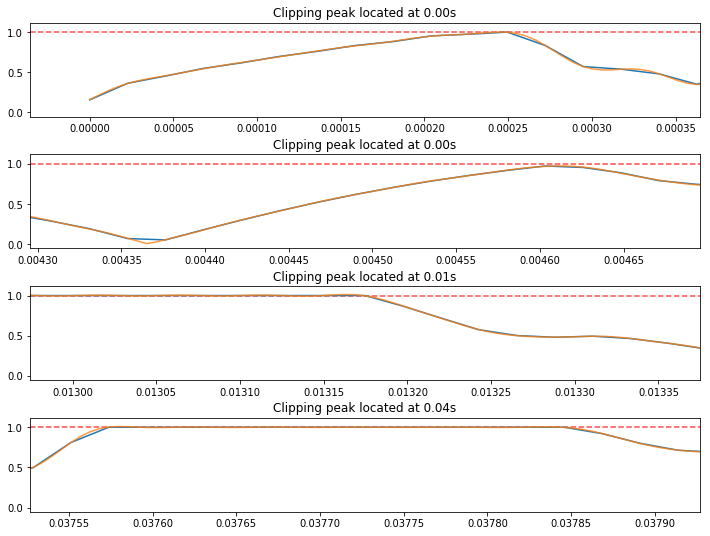

In [39]:
fs = 44100.

audio_dir = '../../audio/'
audio = es.MonoLoader(filename='{}/{}'.format(audio_dir,
                      'recorded/distorted.wav'),
                      sampleRate=fs)()

times = np.linspace(0, len(audio) / fs, len(audio))

peakLocations, output = es.TruePeakDetector(version=2)(audio)

oversampledtimes = np.linspace(0, len(output) / (fs*4), len(output))

random_indexes = [1, 300, 1000, 3000]
fig, ax = plt.subplots(len(random_indexes))
plt.subplots_adjust(hspace=.4)
for idx, ridx in enumerate(random_indexes):
    ax[idx].axhline(1, color='r', alpha=.7, ls = '--')
    l1 = ax[idx].plot(times, np.abs(audio))
    l2 = ax[idx].plot(oversampledtimes, output, alpha=.8)
    
    ax[idx].set_xlim([peakLocations[ridx]  / (fs*4) - .0002, peakLocations[ridx]  / (fs*4) + .0002])
    ax[idx].set_title('Clipping peak located at {:.2f}s'.format(peakLocations[ridx]  / (fs*4)))

# fig.legend((l1, l2), ('Original Signal','Resampled signal'), 'upper right')

Lets listen to the clip to have an idea on how audible the clips are

# The parameters
this is an explanation of the most relevant parameters of the algorithm

- **oversamplingFactor.** 

- **version.**

- **blockDC and emphatise.**
